In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


import sklearn
import xgboost
from xgboost import XGBRegressor


from sklearn.model_selection import KFold

import random as rn

RANDOM_SEED = 2023
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)



from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
df=pd.read_csv('train.csv')

In [4]:
missing_ratio = df.isnull().mean()

# 결측치 비율 출력
print(missing_ratio)

num_date_time    0.000000
건물번호             0.000000
일시               0.000000
기온(C)            0.000000
강수량(mm)          0.784652
풍속(m/s)          0.000093
습도(%)            0.000044
일조(hr)           0.368539
일사(MJ/m2)        0.430946
전력소비량(kWh)       0.000000
dtype: float64


In [11]:
def find_correlation(df):
    correlation_matrix = df.corr()
    return correlation_matrix

# 상관관계 함수 호출
# 'num_data'와 'time' 열을 제외한 열들을 선택합니다.
selected_columns = df.drop(['num_date_time','일시'], axis=1)

# 선택된 열들 간의 상관관계를 계산합니다.
correlation_matrix = selected_columns.corr()

# 결과 출력
print(correlation_matrix)

                건물번호     기온(C)   강수량(mm)   풍속(m/s)     습도(%)    일조(hr)  \
건물번호        1.000000 -0.004505 -0.000248  0.021483  0.022985  0.024927   
기온(C)      -0.004505  1.000000 -0.066500  0.220203 -0.389854  0.387001   
강수량(mm)    -0.000248 -0.066500  1.000000  0.028729  0.271468 -0.098351   
풍속(m/s)     0.021483  0.220203  0.028729  1.000000 -0.219095  0.093043   
습도(%)       0.022985 -0.389854  0.271468 -0.219095  1.000000 -0.574123   
일조(hr)      0.024927  0.387001 -0.098351  0.093043 -0.574123  1.000000   
일사(MJ/m2)   0.009761  0.476193 -0.194009  0.136162 -0.600839  0.781689   
전력소비량(kWh) -0.180474  0.171190  0.015386  0.109954 -0.129546  0.021098   

            일사(MJ/m2)  전력소비량(kWh)  
건물번호         0.009761   -0.180474  
기온(C)        0.476193    0.171190  
강수량(mm)     -0.194009    0.015386  
풍속(m/s)      0.136162    0.109954  
습도(%)       -0.600839   -0.129546  
일조(hr)       0.781689    0.021098  
일사(MJ/m2)    1.000000    0.080357  
전력소비량(kWh)   0.080357    1.000000  


In [4]:
print("pandas version: {}". format(pd.__version__))
print("NumPy version: {}". format(np.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))
print("seaborn version: {}". format(sns.__version__))
print("XGBoost version: {}". format(xgboost.__version__))

pandas version: 2.0.3
NumPy version: 1.25.1
scikit-learn version: 1.3.0
matplotlib version: 3.7.2
seaborn version: 0.12.2
XGBoost version: 2.0.0


In [5]:
def smape(gt, preds):
    gt= np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score

In [6]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [7]:
def custom_smape(preds, dtrain):
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100

데이터 전처리

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
building_info = pd.read_csv('building_info.csv')

In [9]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [10]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [11]:
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}
building_info['building_type'] = building_info['building_type'].replace(translation_dict)

In [12]:
building_info['solar_power_utility'] = np.where(building_info.solar_power_capacity !='-',1,0)
building_info['ess_utility'] = np.where(building_info.ess_capacity !='-',1,0)

In [13]:
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

결측치 확인 및 채우기

In [19]:
train.isna().sum()

building_number              0
date_time                    0
temperature                  0
rainfall                160069
windspeed                    0
humidity                     0
sunshine                 75182
solar_radiation          87913
power_consumption            0
building_type                0
total_area                   0
cooling_area                 0
solar_power_capacity         0
ess_capacity                 0
pcs_capacity                 0
solar_power_utility          0
ess_utility                  0
dtype: int64

In [15]:
train.solar_power_capacity.value_counts()

solar_power_capacity
-         130560
25          4080
20          4080
50          4080
200         4080
28.44       2040
3           2040
9.45        2040
365         2040
14.4        2040
65          2040
95          2040
60.45       2040
621         2040
100         2040
97.85       2040
98.28       2040
46.2        2040
35          2040
100.56      2040
40          2040
83.72       2040
30          2040
26.64       2040
97.65       2040
110         2040
70          2040
64.8        2040
56          2040
130.6       2040
447.2       2040
60          2040
21.6        2040
Name: count, dtype: int64

In [16]:
train.ess_capacity.value_counts()

ess_capacity
-        193800
2557       2040
800        2040
1362       2040
837.1      2040
3100       2040
Name: count, dtype: int64

In [17]:
train.pcs_capacity.value_counts()

pcs_capacity
-       193800
500       4080
1000      2040
300       2040
800       2040
Name: count, dtype: int64

선형보간

In [18]:
train['windspeed']= train.windspeed.interpolate()
train['humidity']= train.humidity.interpolate()

Datetime 분리

In [20]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['day_of_week'] = train['date_time'].dt.dayofweek #요일


test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['month'] = test['date_time'].dt.month
test['day_of_week'] = test['date_time'].dt.dayofweek #요일

In [21]:
def calculate_day_values(dataframe, target_column, output_column, aggregation_func):
    result_dict = {}

    grouped_temp = dataframe.groupby(['building_number', 'month', 'day'])[target_column].agg(aggregation_func)

    for (building, month, day), value in grouped_temp.items():
        result_dict.setdefault(building, {}).setdefault(month, {})[day] = value

    dataframe[output_column] = [
        result_dict.get(row['building_number'], {}).get(row['month'], {}).get(row['day'], None)
        for _, row in dataframe.iterrows()
    ]

    
train['day_max_temperature'] = 0.0
train['day_mean_temperature'] = 0.0

calculate_day_values(train, 'temperature', 'day_max_temperature', 'max')
calculate_day_values(train, 'temperature', 'day_mean_temperature', 'mean')
calculate_day_values(train, 'temperature', 'day_min_temperature', 'min')

train['day_temperature_range'] = train['day_max_temperature'] - train['day_min_temperature']

calculate_day_values(test, 'temperature', 'day_max_temperature', 'max')
calculate_day_values(test, 'temperature', 'day_mean_temperature', 'mean')
calculate_day_values(test, 'temperature', 'day_min_temperature', 'min')

test['day_temperature_range'] = test['day_max_temperature'] - test['day_min_temperature']

In [22]:
test

,building_number,date_time,temperature,rainfall,windspeed,humidity,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,solar_power_utility,ess_utility,hour,day,month,day_of_week,day_max_temperature,day_mean_temperature,day_min_temperature,day_temperature_range
0,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,Other Buildings,110634.00,39570.00,-,-,-,0,0,0,25,8,3,24.0,22.408333,21.2,2.8
1,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,Other Buildings,110634.00,39570.00,-,-,-,0,0,1,25,8,3,24.0,22.408333,21.2,2.8
2,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,Other Buildings,110634.00,39570.00,-,-,-,0,0,2,25,8,3,24.0,22.408333,21.2,2.8
3,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,Other Buildings,110634.00,39570.00,-,-,-,0,0,3,25,8,3,24.0,22.408333,21.2,2.8
4,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,Other Buildings,110634.00,39570.00,-,-,-,0,0,4,25,8,3,24.0,22.408333,21.2,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,2022-08-31 19:00:00,22.5,0.0,0.9,84,Hotel and Resort,57497.84,40035.23,-,-,-,0,0,19,31,8,2,24.5,21.595833,19.1,5.4
16796,100,2022-08-31 20:00:00,20.7,0.0,0.4,95,Hotel and Resort,57497.84,40035.23,-,-,-,0,0,20,31,8,2,24.5,21.595833,19.1,5.4
16797,100,2022-08-31 21:00:00,20.2,0.0,0.4,98,Hotel and Resort,57497.84,40035.23,-,-,-,0,0,21,31,8,2,24.5,21.595833,19.1,5.4
16798,100,2022-08-31 22:00:00,20.1,0.0,1.1,97,Hotel and Resort,57497.84,40035.23,-,-,-,0,0,22,31,8,2,24.5,21.595833,19.1,5.4


In [25]:
outlier_list = [68973,71013,112384,123132,150739,150740,150741,150742,
                150883,150884,150885,150886,138904,193120,193121,152393]
for idx in outlier_list:
    print(train.iloc[idx])
    print("----------")
# train.drop(outlier_list, axis=0,inplace=True)


building_number                           34
date_time                2022-08-08 21:00:00
temperature                             25.9
rainfall                                 1.9
windspeed                                2.1
humidity                                96.0
sunshine                                 NaN
solar_radiation                          NaN
power_consumption                    2631.24
building_type                    Data Center
total_area                           10665.0
cooling_area                          9402.0
solar_power_capacity                       -
ess_capacity                               -
pcs_capacity                               -
solar_power_utility                        0
ess_utility                                0
hour                                      21
day                                        8
month                                      8
day_of_week                                0
day_max_temperature                     28.4
day_mean_t

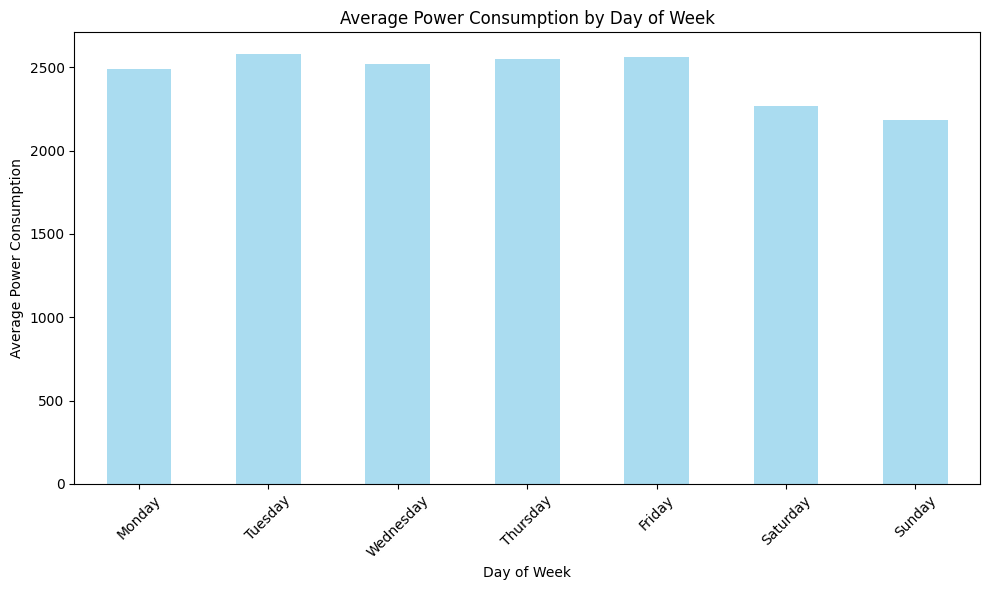

In [26]:
# 데이터프레임에서 'day_of_week' 및 'power_consumption' 열만 선택
day_of_week_power = train[['day_of_week', 'power_consumption']]

# 'day_of_week'로 그룹화하여 'power_consumption'의 평균 계산
day_of_week_power_avg = day_of_week_power.groupby('day_of_week')['power_consumption'].mean()

# 그래프 생성
plt.figure(figsize=(10, 6))
day_of_week_power_avg.plot(kind='bar', color='skyblue', alpha=0.7)

# 그래프 제목과 축 레이블 설정
plt.title('Average Power Consumption by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Power Consumption')

# x 축 레이블 설정 (0: 월요일, 1: 화요일, ..., 6: 일요일)
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(day_of_week_power_avg.index, day_labels, rotation=45)

# 그래프 출력
plt.tight_layout()
plt.show()

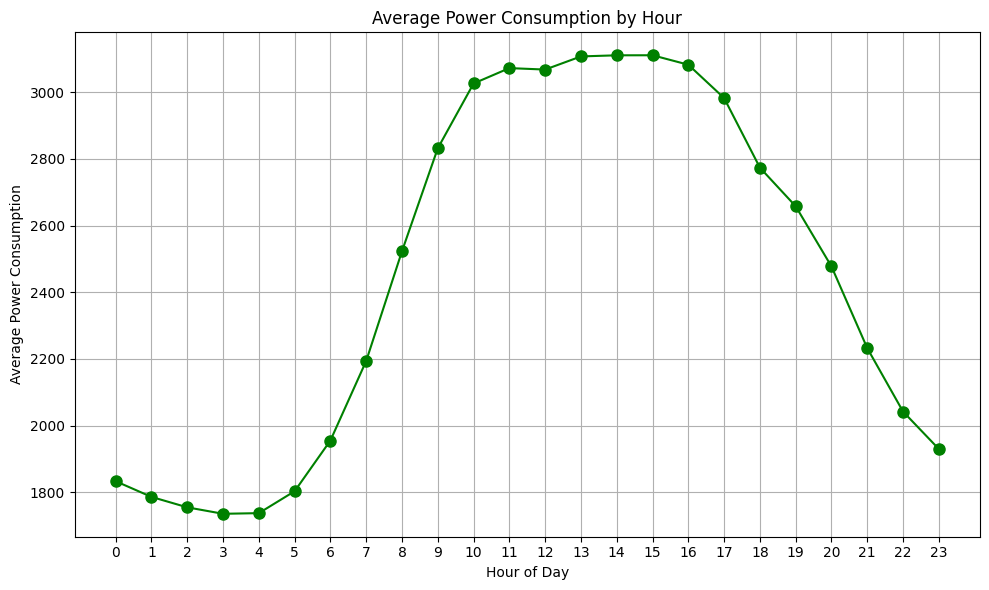

In [27]:
# 데이터프레임에서 'hour' 및 'power_consumption' 열만 선택
hour_power = train[['hour', 'power_consumption']]

# 'hour'로 그룹화하여 'power_consumption'의 평균 계산
hour_power_avg = hour_power.groupby('hour')['power_consumption'].mean()

# 그래프 생성
plt.figure(figsize=(10, 6))
hour_power_avg.plot(kind='line', marker='o', color='green', linestyle='-', markersize=8)

# 그래프 제목과 축 레이블 설정
plt.title('Average Power Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power Consumption')

# x 축 레이블 설정 (0부터 23까지)
plt.xticks(range(24))

# 그래프 출력
plt.tight_layout()
plt.grid(True)
plt.show()

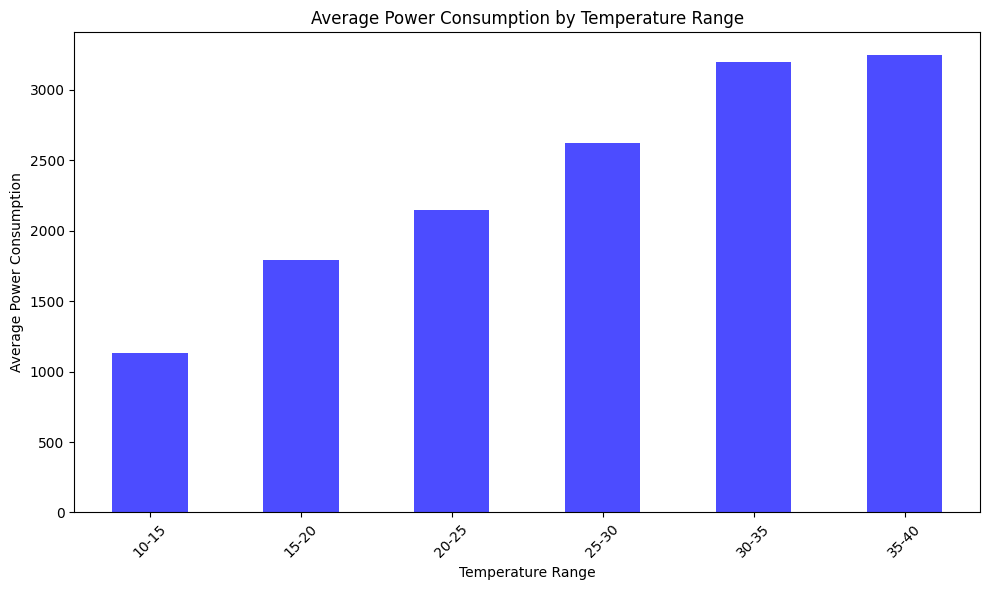

In [28]:
temp_power = train[['temperature', 'power_consumption']]

# 온도 구간을 정의 (예: 5도씩 구간을 나눔)
temp_bins = range(int(temp_power['temperature'].min()), int(temp_power['temperature'].max()) + 6, 5)

# 온도 구간을 기준으로 데이터를 그룹화하고 'power_consumption'의 평균 계산
temp_power_avg = temp_power.groupby(pd.cut(temp_power['temperature'], bins=temp_bins))['power_consumption'].mean()

# 그래프 생성
plt.figure(figsize=(10, 6))
temp_power_avg.plot(kind='bar', color='blue', alpha=0.7)

# 그래프 제목과 축 레이블 설정
plt.title('Average Power Consumption by Temperature Range')
plt.xlabel('Temperature Range')
plt.ylabel('Average Power Consumption')

# x 축 레이블 설정 (온도 구간별로)
temp_labels = [f'{left}-{right}' for left, right in zip(temp_bins[:-1], temp_bins[1:])]
plt.xticks(range(len(temp_labels)), temp_labels, rotation=45)

# 그래프 출력
plt.tight_layout()
plt.show()

In [29]:
temp_hol = {2 : ['2022-06-17'], 
    5 : ['2022-07-25','2022-08-02','2022-08-09','2022-08-16'],
    11 : ['2022-06-17'], 12 : ['2022-07-02'], 17 : ['2022-06-18','2022-07-25'],
    21 : ['2022-07-01','2022-07-03','2022-07-17','2022-07-30'], 
    37 : ['2022-06-20','2022-07-11','2022-08-08'], 
    38 : ['2022-06-13','2022-07-25','2022-08-01'],
    39 : ['2022-07-18','2022-08-08'],
    40 : ['2022-06-20','2022-07-18','2022-08-08'],
    41 : ['2022-06-27','2022-07-25','2022-08-08'],
    42 : ['2022-06-13','2022-07-11','2022-08-22'],
    54 : ['2022-08-16','2022-08-17'],74 : ['2022-06-03'],
    75 : ['2022-06-15','2022-06-17','2022-06-20','2022-06-21'],
    86 : ['2022-06-10','2022-08-10'],
    89 : ['2022-07-09'], 91 : ['2022-06-13','2022-07-11','2022-08-22','2022-06-08'], 92 : ['2022-07-30']}


mask = train.apply(lambda x: x['building_number'] in temp_hol and str(x['date_time'])[:10] in temp_hol[x['building_number']], axis=1)

train.drop(train[mask].index, axis=0, inplace=True)

train.reset_index(drop=True, inplace=True)

시간 변수 퓨리에 변환

In [ ]:
#시간
train['sin_hour'] = np.sin(2 * np.pi * train['hour']/23.0)
train['cos_hour'] = np.cos(2 * np.pi * train['hour']/23.0)
test['sin_hour'] = np.sin(2 * np.pi * test['hour']/23.0)
test['cos_hour'] = np.cos(2 * np.pi * test['hour']/23.0)

#날짜
train['sin_date'] = -np.sin(2 * np.pi * (train['month']+train['day']/31)/12)
train['cos_date'] = -np.cos(2 * np.pi * (train['month']+train['day']/31)/12)
test['sin_date'] = -np.sin(2 * np.pi * (test['month']+test['day']/31)/12)
test['cos_date'] = -np.cos(2 * np.pi * (test['month']+test['day']/31)/12)

#월
train['sin_month'] = -np.sin(2 * np.pi * train['month']/12.0)
train['cos_month'] = -np.cos(2 * np.pi * train['month']/12.0)
test['sin_month'] = -np.sin(2 * np.pi * test['month']/12.0)
test['cos_month'] = -np.cos(2 * np.pi * test['month']/12.0)

#요일
train['sin_dayofweek'] = -np.sin(2 * np.pi * (train['day_of_week']+1)/7.0)
train['cos_dayofweek'] = -np.cos(2 * np.pi * (train['day_of_week']+1)/7.0)
test['sin_dayofweek'] = -np.sin(2 * np.pi * (test['day_of_week']+1)/7.0)
test['cos_dayofweek'] = -np.cos(2 * np.pi * (test['day_of_week']+1)/7.0)